# GFS pre-process

In [2]:
import os
import sys
import time
import h5py
import pygrib

import numpy as np
import netCDF4 as nc
from glob import glob

from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Check GFS availability in RDA

In [4]:
year = 2021
GFS_dir = '/glade/campaign/collections/rda/data/ds084.1/{}/'.format(year)

In [5]:
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]

**Pull grib2 variable table**

* GFS verision change detected. date_list[0-80] v.s. date_list[81-364]
* date_list[81-364] is the FV3 GFS

In [15]:
dt = date_list[80]
filename = datetime.strftime(dt, 
    '/glade/campaign/collections/rda/data/ds084.1/%Y/%Y%m%d/gfs.0p25.%Y%m%d{}.f{:03d}.grib2'.format('00', 3))

# append all available grbio info until indices run out-of-bound
names = []
with pygrib.open(filename) as grbio:
    for i in range(1, 600):
        names.append(grbio[i])

OSError: not that many messages in file

In [16]:
str(names[315])

'316:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 80000 Pa:fcst time 3 hrs:from 202103220000'

In [17]:
# with pygrib.open(filename) as grbio:
#     precip1 = grbio[450].values

## Variable subsetting

**Predictors**
* Temperature:K (instant):regular_ll:isobaricInhPa:level 80000 Pa:fcst time
* U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 8000
* V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 8000
* Relative humidity:% (instant):regular_ll:isobaricInhPa:level 80000 Pa:fcs
* Total Precipitation:kg m**-2 (accum):regular_ll:surface:level 0:fcst time
* Convective available potential energy:J kg**-1 (instant):regular_ll:surfa
* Precipitable water:kg m**-2 (instant):regular_ll:atmosphereSingleLayer:le

**Spatial coverage**
* lat_ind 98:203; lon_ind 218:460 for CONUS

In [18]:
with pygrib.open(filename) as grbio:
    lat, lon = grbio[314+1].latlons()
    T = grbio[314+1].values
    U = grbio[319+1].values
    V = grbio[320+1].values
    RH = grbio[315+1].values
    APCP = grbio[450+1].values
    CAPE = grbio[473+1].values
    PWAT = grbio[475+1].values

T_NA = T[:-360, 720:]
T_NA = np.flipud(T_NA)[98:203, 218:460]

U_NA = U[:-360, 720:]
U_NA = np.flipud(U_NA)[98:203, 218:460]

V_NA = V[:-360, 720:]
V_NA = np.flipud(V_NA)[98:203, 218:460]

RH_NA = RH[:-360, 720:]
RH_NA = np.flipud(RH_NA)[98:203, 218:460]

APCP_NA = APCP[:-360, 720:]
APCP_NA = np.flipud(APCP_NA)[98:203, 218:460]

CAPE_NA = CAPE[:-360, 720:]
CAPE_NA = np.flipud(CAPE_NA)[98:203, 218:460]

PWAT_NA = PWAT[:-360, 720:]
PWAT_NA = np.flipud(PWAT_NA)[98:203, 218:460]

**Raw GFS and raw MRMS are flipud with 90N latitude on index-0**

In [13]:
lat_NA = np.flipud(lat[:-360, 720:])
lon_NA = np.flipud(lon[:-360, 720:]) - 360

lat_GFS = lat_NA[98:203, 218:460]
lon_GFS = lon_NA[98:203, 218:460]

## Save GFS subsetting lat/lons to the geo-reference file

In [15]:
# with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
#     lon_01 = h5io['lon_01'][...]
#     lat_01 = h5io['lat_01'][...]
#     elev_01 = h5io['elev_01'][...]
#     land_mask_01 = h5io['land_mask_01'][...]

# tuple_save = (lon_01, lat_01, elev_01, land_mask_01, lon_GFS, lat_GFS)
# label_save = ['lon_01', 'lat_01', 'elev_01', 'land_mask_01', 'lon_GFS', 'lat_GFS']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_domain.hdf')

Save to /glade/work/ksha/GAN/CNN_domain.hdf


## Data visualization check

In [24]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

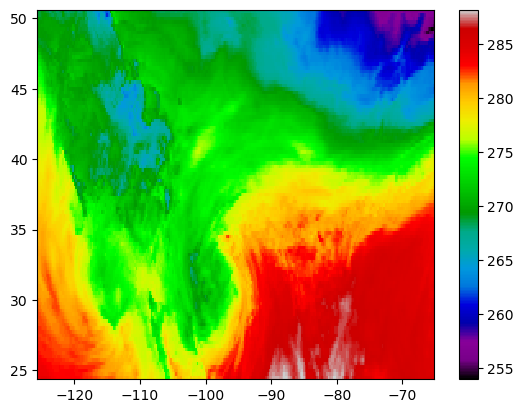

In [27]:
plt.pcolormesh(lon_GFS, lat_GFS, T_NA, cmap=plt.cm.nipy_spectral)
plt.colorbar()

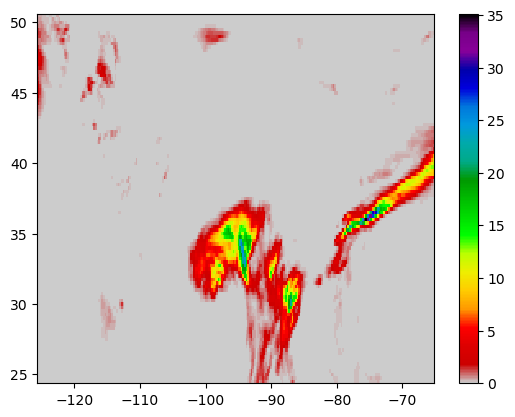

In [26]:
plt.pcolormesh(lon_GFS, lat_GFS, APCP_NA, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

## GFS file name check

In [10]:
sorted(glob(GFS_dir+'*/gfs*'))

['/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f003.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f006.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f009.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f012.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f015.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f018.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f021.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f024.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f027.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101/gfs.0p25.2021010100.f030.grib2',
 '/glade/campaign/collections/rda/data/ds084.1/2021/20200101